# Generate some reference images & gradients.

In [2]:
#@title: Imports
# Train a whole image, see how that progresses for reference.
# Maybe capture first training step as something... ?
import math
import os
import time
from pathlib import Path
from typing import Optional
import mediapy

import numpy as np
import torch
from gsplat.project_gaussians import project_gaussians
from gsplat.rasterize import rasterize_gaussians
from gsplat.sh import spherical_harmonics

from PIL import Image
from torch import Tensor, optim

In [3]:
from safetensors import safe_open
from safetensors.torch import save_file

In [16]:
def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms
    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor.to("cuda:0")

""

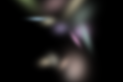

""

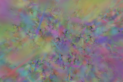

In [90]:
crab_img = image_path_to_tensor("./crab.png")

# Super simple case: a few splats visibile in a tiny image.
def test_case():
    torch.manual_seed(4)
    device = torch.device("cuda:0")
    num_points = 16
    fov_x = math.pi / 2.0
    H, W, _ = crab_img.shape
    focal = 0.5 * float(W) / math.tan(0.5 * fov_x)
    means = 7.5 * (torch.rand(num_points, 3, device=device) - 0.5)
    log_scales = torch.rand(num_points, 3, device=device).log() * 0.5
    coeffs = torch.rand(num_points, 1, 3, device=device)
    u = torch.rand(num_points, 1, device=device)
    v = torch.rand(num_points, 1, device=device)
    w = torch.rand(num_points, 1, device=device)
    quats = torch.cat(
        [
            torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
            torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
            torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
            torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
        ],
        -1,
    )
    opacities = torch.rand(num_points, device=device) * 0.5 + 0.5

    # TODO: Our coords are flipped or?
    viewmat = torch.tensor(
        [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 8.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
        device=device,
    )
    background = torch.zeros(3, device=device)

    means.requires_grad = True
    log_scales.requires_grad = True
    quats.requires_grad = True
    coeffs.requires_grad = True
    opacities.requires_grad = True
    viewmat.requires_grad = False

    B_SIZE = 16

    (
        xys,
        depths,
        radii,
        conics,
        _compensation,
        num_tiles_hit,
        _cov3d,
    ) = project_gaussians(
        means,
        log_scales.exp(),
        1,
        quats,
        viewmat,
        focal,
        focal,
        W / 2,
        H / 2,
        H,
        W,
        B_SIZE,
        0.01
    )

    viewdirs = means - viewmat[:3, 3]  # (N, 3)
    colors = spherical_harmonics(0, viewdirs, coeffs, "fast") + 0.5

    out_img = rasterize_gaussians(
        xys,
        depths,
        radii,
        conics,
        num_tiles_hit,
        colors,
        torch.sigmoid(opacities[:, None]),
        H,
        W,
        B_SIZE,
        background,
    )[..., :3]
    out_img.retain_grad()
    conics.retain_grad()
    xys.retain_grad()
    mediapy.show_image((out_img.detach().cpu().numpy() * 255.0).astype(np.uint8), width=W*4, height=H*4)

    loss = ((out_img - crab_img) ** 2).mean()
    loss.backward()
    tensors = {
        "means": means,
        "scales": log_scales,
        "coeffs": coeffs,
        "quats": quats,
        "opacities": opacities,
        "depths": depths,
        "xys": xys,
        "radii": radii,
        "conics": conics,
        "out_img": out_img,

        "v_xy": xys.grad,
        "v_conics": conics.grad,


        "v_means": means.grad,
        "v_scales": log_scales.grad,
        "v_coeffs": coeffs.grad,
        "v_quats": quats.grad,
        "v_opacities": opacities.grad,
        "v_out_img": out_img.grad,
    }
    save_file(tensors, "./basic_case.safetensors")

test_case()

# Super simple case: a few splats visibile in a tiny image.
def test_case():
    torch.manual_seed(4)
    device = torch.device("cuda:0")
    num_points = 76873

    fov_x = math.pi / 2.0
    H, W, _ = crab_img.shape
    focal = 0.5 * float(W) / math.tan(0.5 * fov_x)

    means = 2000.0 * (torch.rand(num_points, 3, device=device) - 0.5)
    log_scales = (torch.rand(num_points, 3, device=device) * 15.0 + 0.05).log()
    coeffs = torch.rand(num_points, 1, 3, device=device) * 2.0 - 1.0

    u = torch.rand(num_points, 1, device=device)
    v = torch.rand(num_points, 1, device=device)
    w = torch.rand(num_points, 1, device=device)

    # TODO: Why not just ID?
    quats = torch.cat(
        [
            torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
            torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
            torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
            torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
        ],
        -1,
    )
    opacities = torch.rand(num_points, device=device)
    viewmat = torch.tensor(
        [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 8.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
        device=device,
    )
    background = torch.zeros(3, device=device)

    means.requires_grad = True
    log_scales.requires_grad = True
    quats.requires_grad = True
    coeffs.requires_grad = True
    opacities.requires_grad = True
    viewmat.requires_grad = False
    B_SIZE = 16
    (
        xys,
        depths,
        radii,
        conics,
        _compensation,
        num_tiles_hit,
        _cov3d,
    ) = project_gaussians(
        means,
        log_scales.exp(),
        1,
        quats,
        viewmat,
        focal,
        focal,
        W / 2,
        H / 2,
        H,
        W,
        B_SIZE,
    )

    viewdirs = means - viewmat[:3, 3]
    colors = spherical_harmonics(0, viewdirs, coeffs, "fast") + 0.5
    out_img = rasterize_gaussians(
        xys,
        depths,
        radii,
        conics,
        num_tiles_hit,
        colors,
        torch.sigmoid(opacities[:, None]),
        H,
        W,
        B_SIZE,
        background,
    )[..., :3]
    out_img.retain_grad()
    xys.retain_grad()
    conics.retain_grad()
    mediapy.show_image((out_img.detach().cpu().numpy() * 255.0).astype(np.uint8), width=W*4, height=H*4)
    loss = ((out_img - crab_img) ** 2).mean()
    loss.backward()
    tensors = {
        "means": means,
        "scales": log_scales,
        "coeffs": coeffs,
        "quats": quats,
        "opacities": opacities,
        "depths": depths,
        "xys": xys,
        "radii": radii,
        "conics": conics,
        "out_img": out_img,

        "v_xy": xys.grad,
        "v_conics": conics.grad,

        "v_means": means.grad,
        "v_scales": log_scales.grad,
        "v_coeffs": coeffs.grad,
        "v_quats": quats.grad,
        "v_opacities": opacities.grad,
        "v_out_img": out_img.grad,
    }
    save_file(tensors, "./mix_case.safetensors")

test_case()

In [ ]:

test_case()

In [5]:
class SimpleTrainer:
    """Trains random gaussians to fit an image."""
    def __init__(
        self,
        gt_image: Tensor,
        num_points: int = 2000,
    ):
        self.device = torch.device("cuda:0")
        self.gt_image = gt_image.to(device=self.device)
        self.num_points = num_points

        fov_x = math.pi / 2.0
        self.H, self.W = gt_image.shape[0], gt_image.shape[1]
        self.focal = 0.5 * float(self.W) / math.tan(0.5 * fov_x)
        self.img_size = torch.tensor([self.W, self.H, 1], device=self.device)

        self._init_gaussians()

    def _init_gaussians(self):
        """Random gaussians"""
        bd = 4.0
        self.means = bd * (torch.rand(self.num_points, 3, device=self.device) - 0.5)
        self.scales = torch.rand(self.num_points, 3, device=self.device)
        self.rgbs = torch.rand(self.num_points, 3, device=self.device)

        u = torch.rand(self.num_points, 1, device=self.device)
        v = torch.rand(self.num_points, 1, device=self.device)
        w = torch.rand(self.num_points, 1, device=self.device)

        self.quats = torch.cat(
            [
                torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
                torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
                torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
                torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
            ],
            -1,
        )
        self.opacities = torch.ones((self.num_points, 1), device=self.device)

        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )
        self.background = torch.zeros(3, device=self.device)

        self.means.requires_grad = True
        self.scales.requires_grad = True
        self.quats.requires_grad = True
        self.rgbs.requires_grad = True
        self.opacities.requires_grad = True
        self.viewmat.requires_grad = False

    def train(
        self,
        iterations: int = 1000,
        lr: float = 0.01,
        save_imgs: bool = False,
        B_SIZE: int = 14,
    ):
        optimizer = optim.Adam(
            [self.rgbs, self.means, self.scales, self.opacities, self.quats], lr
        )
        mse_loss = torch.nn.MSELoss()
        frames = []
        times = [0] * 3  # project, rasterize, backward
        B_SIZE = 16
        for iter in range(iterations):
            start = time.time()

            (
                xys,
                depths,
                radii,
                conics,
                compensation,
                num_tiles_hit,
                cov3d,
            ) = project_gaussians(
                self.means,
                self.scales,
                1,
                self.quats / self.quats.norm(dim=-1, keepdim=True),
                self.viewmat,
                self.focal,
                self.focal,
                self.W / 2,
                self.H / 2,
                self.H,
                self.W,
                B_SIZE,
            )

            start = time.time()
            out_img = rasterize_gaussians(
                xys,
                depths,
                radii,
                conics,
                num_tiles_hit,
                torch.sigmoid(self.rgbs),
                torch.sigmoid(self.opacities),
                self.H,
                self.W,
                B_SIZE,
                self.background,
            )[..., :3]
            loss = mse_loss(out_img, self.gt_image)
            optimizer.zero_grad()
            start = time.time()
            loss.backward()
            optimizer.step()

            if save_imgs and iter % 5 == 0:
                mediapy.show_image((out_img.detach().cpu().numpy() * 255).astype(np.uint8))

def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms
    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor


def main(
    height: int = 256,
    width: int = 256,
    num_points: int = 100000,
    save_imgs: bool = True,
    img_path: Optional[Path] = None,
    iterations: int = 1000,
    lr: float = 0.01,
) -> None:
    if img_path:
        gt_image = image_path_to_tensor(img_path)
    else:
        gt_image = torch.ones((height, width, 3)) * 1.0
        # make top left and bottom right red, blue
        gt_image[: height // 2, : width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
        gt_image[height // 2 :, width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

    trainer = SimpleTrainer(gt_image=gt_image, num_points=num_points)
    trainer.train(
        iterations=iterations,
        lr=lr,
        save_imgs=save_imgs,
    )

main(img_path="./CrabTest.png")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\A-Bru\\Documents\\Projects\\Brush\\test_cases\\CrabTest.png'